In [1]:
import psycopg2
import numpy as np
import pandas as pd
from itertools import islice

import math
import sklearn as sk
import xgboost as xg
import statsmodels.tsa.stattools as sm_tools
import statsmodels.tsa.arima_model as stats_arima

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from finance.utilities import utils, financial_utils, time_series_utils

### Stocks

In [2]:
query = """
    select 
        e.symbol
        , e.market_datetime
        , e.open
        , e.high
        , e.low
        , e.close
        , e.volume
        , f.high_52
        , f.low_52
        , f.dividend_amount
        , f.pe_ratio
        , f.quick_ratio
        , f.current_ratio
    from td.equities as e
    left join td.fundamentals as f 
        on f.symbol = e.symbol
    where e.symbol = 'BA'
    order by e.market_datetime
    """

df = utils.query_db(db_connection=utils.DW_STOCKS_JUPYTER, query=query)

In [3]:
df.index = pd.DatetimeIndex(df.market_datetime, freq = None)
df.index.names = ['date']
df = df.sort_index()

df = df.resample('B').bfill()
df.head()

,symbol,market_datetime,open,high,low,close,volume,high_52,low_52,dividend_amount,pe_ratio,quick_ratio,current_ratio
date,,,,,,,,,,,,,
1999-09-03,BA,1999-09-03 05:00:00,45.1875,45.6250,45.1875,45.4375,2191300.0,446.01,292.4704,8.22,41.51634,0.28874,1.0317
1999-09-06,BA,1999-09-07 05:00:00,45.4375,45.6250,44.8750,44.9375,1906600.0,446.01,292.4704,8.22,41.51634,0.28874,1.0317
1999-09-07,BA,1999-09-07 05:00:00,45.4375,45.6250,44.8750,44.9375,1906600.0,446.01,292.4704,8.22,41.51634,0.28874,1.0317
1999-09-08,BA,1999-09-08 05:00:00,44.8125,44.8125,44.3125,44.5625,2095200.0,446.01,292.4704,8.22,41.51634,0.28874,1.0317
1999-09-09,BA,1999-09-09 05:00:00,44.5625,45.2500,44.3750,45.1250,2109000.0,446.01,292.4704,8.22,41.51634,0.28874,1.0317


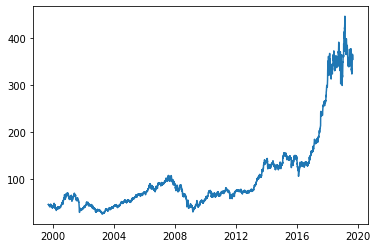

In [4]:
plt.plot(df['market_datetime'], df['open'])
plt.show()

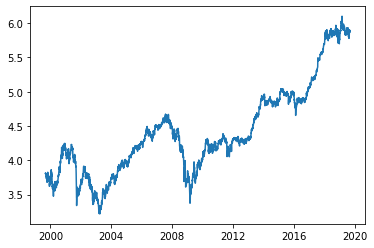

In [5]:
plt.plot(df['market_datetime'], np.log(df['open']))
plt.show()

/Users/rickbetzler/anaconda3/envs/babylon/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


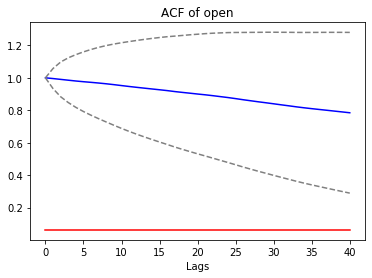

In [6]:
time_series_utils.ARIMA(series=df['open']).acf_plot()

<Figure size 432x288 with 0 Axes>

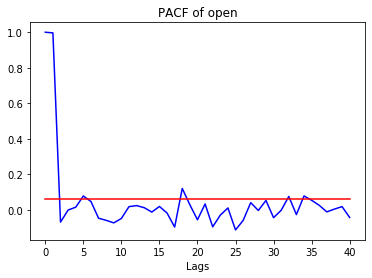

In [7]:
time_series_utils.ARIMA(series=df['open']).pacf_plot()

In [8]:
adf = sm_tools.adfuller(df['open'].values)

print('P-Value:             ' + str(adf[1]))
print('Critical Value 1%:   ' + str(adf[4]['1%']))
print('Critical Value 5%:   ' + str(adf[4]['5%']))
print('Critical Value 10%:  ' + str(adf[4]['10%']))

P-Value:             0.9945586315936696
Critical Value 1%:   -3.4316098758663207
Critical Value 5%:   -2.8620967334513945
Critical Value 10%:  -2.5670663491085057


In [9]:
df_open = df['open']
df_open.head()

date
1999-09-03    45.1875
1999-09-06    45.4375
1999-09-07    45.4375
1999-09-08    44.8125
1999-09-09    44.5625
Freq: B, Name: open, dtype: float64

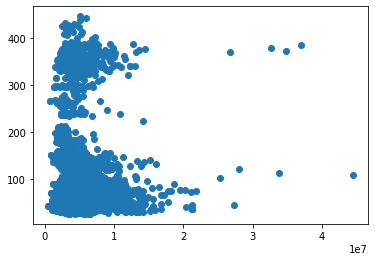

In [10]:
plt.scatter(df['volume'], df['open'])
plt.show()

### Options and Black Scholes

In [11]:
query = """
    select *
    from td.options 
    where symbol = 'BA'
    """

options = utils.query_db(db_connection=utils.DW_STOCKS_JUPYTER, query=query)

In [12]:
options[options['description'].str.contains('BA Sep 20 2019')].T

,115,116,117,118,119,120,121,122,123,124,...,995,996,997,998,999,1000,1001,1002,1003,1004
symbol,BA,BA,BA,BA,BA,BA,BA,BA,BA,BA,...,BA,BA,BA,BA,BA,BA,BA,BA,BA,BA
volatility,29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
n_contracts,1630,1630,1630,1630,1630,1630,1630,1630,1630,1630,...,1630,1630,1630,1630,1630,1630,1630,1630,1630,1630
interest_rate,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,...,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788,2.42788
put_call,CALL,CALL,CALL,CALL,CALL,CALL,CALL,CALL,CALL,CALL,...,PUT,PUT,PUT,PUT,PUT,PUT,PUT,PUT,PUT,PUT
description,BA Sep 20 2019 185 Call,BA Sep 20 2019 190 Call,BA Sep 20 2019 195 Call,BA Sep 20 2019 200 Call,BA Sep 20 2019 205 Call,BA Sep 20 2019 210 Call,BA Sep 20 2019 215 Call,BA Sep 20 2019 220 Call,BA Sep 20 2019 225 Call,BA Sep 20 2019 230 Call,...,BA Sep 20 2019 460 Put,BA Sep 20 2019 465 Put,BA Sep 20 2019 470 Put,BA Sep 20 2019 475 Put,BA Sep 20 2019 480 Put,BA Sep 20 2019 485 Put,BA Sep 20 2019 490 Put,BA Sep 20 2019 500 Put,BA Sep 20 2019 520 Put,BA Sep 20 2019 540 Put
exchange_name,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR,...,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR,OPR
bid,171.55,166.55,161.55,156.55,151.55,146.6,141.6,136.6,131.6,126.6,...,103.15,108.15,113.15,118.15,123.15,128.15,133.15,143.15,163.15,183.15
ask,172.05,167.05,162.05,157.05,152.1,147.1,142.1,137.1,132.1,127.1,...,103.65,108.65,113.65,118.65,123.65,128.65,133.65,143.65,163.65,183.65
last,0,170.65,163.85,131.5,0,0,0,0,133.1,101.71,...,82.84,0,0,110.85,126.6,131.5,128.1,127.8,166,184.55


In [20]:
option = financial_utils.BlackScholes(
    current_stock_price=450,
    strike_price=385,
    risk_free_rate=1.025,
    days_to_maturity=60,
    volatility=.5,
    call_put='call'
)

In [21]:
print('Theoretical option price: $' + str(round(option.option_price, 2)))

Theoretical option price: $76.84


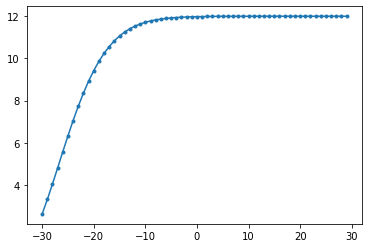

In [22]:
deltas = option.get_greek(greek='delta', steps=30)
plt.plot(deltas, marker='.')
plt.show()

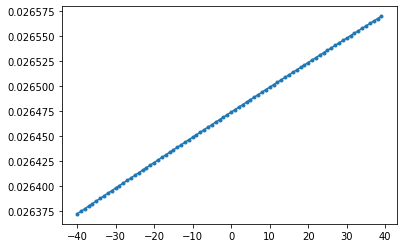

In [23]:
ros = option.get_greek(greek='ro', steps=40)
plt.plot(ros, marker='.')
plt.show()

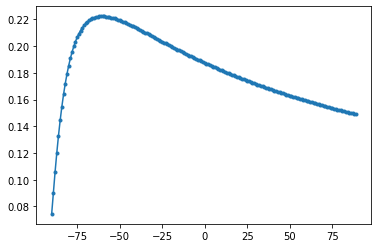

In [24]:
thetas = option.get_greek('theta', steps=90)
plt.plot(thetas, marker='.')
plt.show()

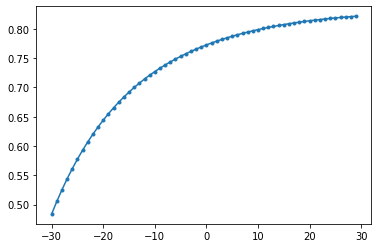

In [25]:
vegas = option.get_greek(greek='vega', steps=30)
plt.plot(vegas, marker='.')
plt.show()

In [40]:
chain = options[options['description'].str.contains('BA Sep 20 2019')]
chain = options[(options['description'].str.contains('BA Sep 20 2019')) & (options['put_call']=='CALL')]

In [41]:
chain.head(1).T

,115
symbol,BA
volatility,29
n_contracts,1630
interest_rate,2.42788
put_call,CALL
description,BA Sep 20 2019 185 Call
exchange_name,OPR
bid,171.55
ask,172.05
last,0


In [42]:
imp_vols = []
current_stock_price = 354.42
risk_free_rate=1.025
volatility=.5
for idw, row in chain.iterrows():
    imp_vol = financial_utils.BlackScholes(
        current_option_price=row['close_price'],
        current_stock_price=current_stock_price,
        strike_price=row['strike'],
        risk_free_rate=risk_free_rate,
        days_to_maturity=row['days_to_expiration_date'],
        volatility=volatility,
        call_put=row['put_call'].lower()
    ).implied_volatility
    imp_vols.append(imp_vol)

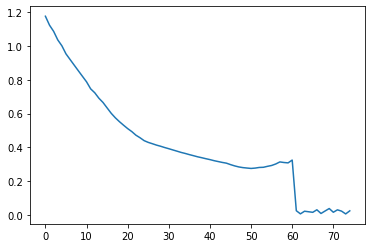

In [43]:
imp_vols = pd.DataFrame(imp_vols)
plt.figure()
plt.plot(imp_vols)
plt.show()

In [39]:
chain.put_call.unique()

array(['CALL', 'PUT'], dtype=object)